In [1]:
import os
import warnings
from collections import Counter
from importlib import reload
from time import time

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import umap.plot

import graphistry
from data import get_reddit_dataframe
from graphistry import constants as config

warnings.filterwarnings('ignore')

Using backend: pytorch


In [2]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="...", password="...") 

In [3]:
tdf = get_reddit_dataframe(nrows=12000, min_doc_length=100)

[__init__.py:7 - get_reddit_dataframe() ]
   Loading Reddit Data and pruning to documents with at least 100 words, and returning random sample of 12000 rows



# We want to take in textual data, featurize it, and then generate an implicit edge dataframe gotten from UMAP-ing the features

# We can split the data depending on what we want to test

In [4]:
text_cols = ['title', 'document']
good_cols = text_cols + ['user', 'type', 'label']

In [5]:
splits = False
if splits:
    ndf = tdf[['title','document']]
    ndf['n'] = range(len(ndf))
    ndf = ndf.astype(str)
    ldf = tdf[['label' ,'type']]
    cnt = Counter(ldf.label)
else:
    ndf = tdf[good_cols] # for now this is perfect
    cnt = Counter(ndf.label)
    #ndf['n'] = range(len(ndf))
    #ndf = ndf.astype(str) # cast as strings or the featurization might throw errors

In [6]:
cnt.most_common(20)

[('relationships', 99),
 ('sysadmin', 97),
 ('startups', 93),
 ('changemyview', 87),
 ('mentalhealth', 84),
 ('entitledparents', 83),
 ('personalfinance', 80),
 ('family', 80),
 ('learnprogramming', 76),
 ('statistics', 75),
 ('books', 70),
 ('buildapc', 68),
 ('tax', 67),
 ('productivity', 66),
 ('raisedbynarcissists', 65),
 ('relationship_advice', 65),
 ('leaves', 64),
 ('loseit', 64),
 ('techsupport', 62),
 ('investing', 61)]

In [7]:
len(cnt) # lots and lots of classes. 

855

In [8]:
# lets reduce it so we have better predictive model downstream (ie, train, test might have only 1 example for low cardinality classes)
top_classes = [cat for cat, c in cnt.most_common() if c>20]
top_classes

['relationships',
 'sysadmin',
 'startups',
 'changemyview',
 'mentalhealth',
 'entitledparents',
 'personalfinance',
 'family',
 'learnprogramming',
 'statistics',
 'books',
 'buildapc',
 'tax',
 'productivity',
 'raisedbynarcissists',
 'relationship_advice',
 'leaves',
 'loseit',
 'techsupport',
 'investing',
 'findapath',
 'docker',
 'devops',
 'TrueFilm',
 'tifu',
 'AskHistorians',
 'careerguidance',
 'BPD',
 'podcasts',
 'aws',
 'Dentistry',
 'learnmachinelearning',
 'askphilosophy',
 'Parenting',
 'keto',
 'medical',
 'sad',
 'legaladvice',
 'IWantOut',
 'webdev',
 'running',
 'socialskills',
 'dating_advice',
 'math',
 'seduction',
 'writing',
 'stopdrinking',
 'datascience',
 'history',
 'selfimprovement',
 'xxfitness',
 'askscience',
 'solotravel',
 'depression',
 'jobs',
 'legal',
 'getdisciplined',
 'FanTheories',
 'pornfree',
 'engineering',
 'smallbusiness',
 'philosophy',
 'astrology',
 'linuxadmin',
 'movies',
 'iwantout',
 'javahelp',
 'Python',
 'RealEstate',
 'offmych

In [115]:
# reduce subreddit categories from above to this, 
len(top_classes)

187

In [9]:
ndf = ndf[ndf.label.isin(top_classes)]

# Let's featurize the nodes

In [10]:
g = graphistry.nodes(ndf)

In [11]:
double_target = pd.DataFrame({'label': ndf.label.values, 'type': ndf['type'].values})
single_target = pd.DataFrame({'label': ndf.label.values})

In [12]:
ndf[good_cols]

,title,document,user,type,label
2139309,NEW METAPHOR: Automatic car vs Manual car. My ...,"My brain is a vehicle, getting me places. Peop...",None,subs,ADHD
9119685,Anyone know what's up with my neighbor?,TL;DR - neighbor is acting very strangely and ...,/u/Recent_Tadpole_706,summary,advice
4309559,I(23F) brought up to my bf(28M) that I'm unhap...,"Sorry, this turned out very long. I just wante...",None,subs,relationships
1222530,What cooking pots and pans do you use most?,Inspired by that recent thread about the diffe...,None,subs,Cooking
3545420,on Will i ever be normal?,"I am at 142 days and yeah, the brain fog stuck...",None,comments,leaves
...,...,...,...,...,...
1938160,on Thinking about majoring in Biotechnology. C...,I do research in experimental therapeutics and...,None,comments,biotech
3586344,Update: I [F21] am supposed to be having thank...,"Hi, my original post got attention from a few ...",None,subs,relationship_advice
2139348,I feel like I can only enjoy myself on the day...,Yesterday I had a 3 hour shift from 4pm to 7pm...,None,subs,Anxiety
7932244,What can I do to get her out?,EDIT: Me - 26. Her - 23(?). I already know the...,/u/randsom1,summary,dating_advice


In [13]:
# these work, uncomment to test
#g2 = g.featurize(kind='nodes', y = double_target, use_columns=good_cols)#['user', 'type'])
#g2 = g.featurize(kind='nodes', y = single_target)
g2 = g.featurize(kind = 'nodes', y = single_target, use_columns=text_cols, use_scaler='robust')

[feature_utils.py:861 - get_dataframe_columns() ]
   returning DataFrame with columns `['title', 'document']`

[feature_utils.py:158 - check_target_not_in_features() ]
   Removing [] columns from DataFrame

[feature_utils.py:470 - check_if_textual_column() ]
   
	Column `title` looks textual with mean number of words 11.05

[feature_utils.py:470 - check_if_textual_column() ]
   
	Column `document` looks textual with mean number of words 251.10

[feature_utils.py:520 -       encode_textual() ]
   -Calculating Embeddings for column `title`

[feature_utils.py:520 -       encode_textual() ]
   -Calculating Embeddings for column `document`

[feature_utils.py:523 -       encode_textual() ]
   Encoded Textual data at 440.16 rows per column minute

[feature_utils.py:680 - process_dirty_dataframes() ]
   *Given DataFrame seems to be empty

[feature_utils.py:685 - process_dirty_dataframes() ]
   -Fitting Targets --


[feature_utils.py:697 - process_dirty_dataframes() ]
   -Shape of target (7061,

In [14]:
#g3 = g.featurize(kind = 'nodes', y = g2.node_target, use_columns=['title', 'document'])

In [15]:
g2.node_target.describe()

,label_ADHD,label_Advice,label_Android,label_Anxiety,label_AskCulinary,label_AskEngineers,label_AskHR,label_AskHistorians,label_AskTechnology,label_BPD,...,label_userexperience,label_virtualreality,label_vuejs,label_web_design,label_webdev,label_windows,label_writing,label_xxfitness,label_yoga,label_zen
count,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,...,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000
mean,0.004957,0.003824,0.003399,0.004532,0.004815,0.002974,0.004390,0.007931,0.004249,0.007931,...,0.004107,0.003257,0.002974,0.004107,0.006656,0.005098,0.006373,0.006090,0.003682,0.004249
std,0.070235,0.061723,0.058205,0.067172,0.069229,0.054458,0.066119,0.088708,0.065048,0.088708,...,0.063959,0.056984,0.054458,0.063959,0.081320,0.071226,0.079582,0.077805,0.060574,0.065048
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
g2.node_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
count,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,...,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000,7061.000000
mean,-0.020086,0.013792,-0.013458,-0.001723,0.011439,0.002542,0.007799,0.012435,-0.000498,-0.001411,...,-0.005133,-0.012882,0.003595,-0.023852,0.016432,-0.022783,-0.004219,-0.028831,0.010427,-0.004989
std,0.738146,0.771301,0.742253,0.769184,0.795377,0.761136,0.762686,0.762875,0.762061,0.772632,...,0.759998,0.742236,0.742306,0.740537,0.782197,0.756434,0.727243,0.753952,0.753818,0.748587
min,-3.069200,-3.279250,-3.296380,-3.267570,-3.017220,-3.128100,-2.676520,-3.031120,-2.841330,-3.352780,...,-3.206830,-3.021430,-2.900470,-3.818360,-2.818570,-3.400090,-2.890880,-3.521000,-3.343620,-3.160840
25%,-0.508660,-0.492570,-0.495290,-0.497290,-0.493640,-0.493580,-0.497350,-0.484150,-0.495280,-0.497410,...,-0.509280,-0.514840,-0.499750,-0.515940,-0.478710,-0.507590,-0.500490,-0.516790,-0.495690,-0.513860
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.491340,0.507430,0.504710,0.502710,0.506360,0.506420,0.502650,0.515850,0.504720,0.502590,...,0.490720,0.485160,0.500250,0.484060,0.521290,0.492410,0.499510,0.483210,0.504310,0.486140
max,2.878100,3.298240,2.612270,3.065380,3.925980,3.055540,2.999540,3.095290,2.935840,3.313440,...,3.158960,2.981850,2.686380,2.708990,2.512800,2.662140,3.028460,2.486180,2.784560,3.319900


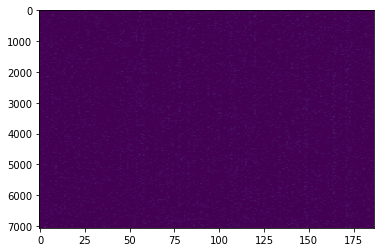

In [17]:
if hasattr(g2, 'node_target'):
    plt.imshow(g2.node_target, aspect='auto')

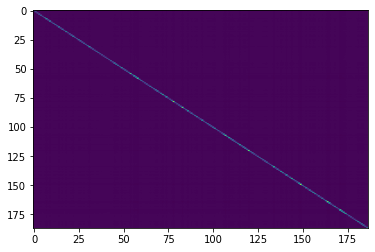

In [18]:
if hasattr(g2, 'node_target'):
    plt.imshow(np.cov(g2.node_target.T), aspect='auto')

In [114]:
# if hasattr(g2, 'node_target_encoder') and g2.node_target_encoder is not None:
#     t_feats = g2.node_target_encoder.get_feature_names_out()
#     res = list(zip(ndf.label, [t_feats[k] for k in g2.node_target.values.argmax(1)]))
#     print(res)

In [20]:
g2.node_target_encoder

SuperVectorizer(cardinality_threshold=400)

In [21]:
g3=g2.umap(scale=0.1, n_neighbors=25, min_dist=0.1)

[feature_utils.py:1240 -                 umap() ]
   Relabeling nodes

[feature_utils.py:1069 - _featurize_or_get_nodes_dataframe_if_X_is_None() ]
   Found Node features in `res`

[feature_utils.py:1092 - _featurize_or_get_nodes_dataframe_if_X_is_None() ]
   Fetching `node_target` in `res`. Target is type <class 'pandas.core.frame.DataFrame'>

[umap_utils.py:84 - _check_target_is_one_dimensional() ]
   * Ignoring target column of shape (7061, 187) as it is not one dimensional

[umap_utils.py:92 -                  fit() ]
   Starting UMAP-ing data of shape (7061, 768)

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[umap_utils.py:105 -      _edge_influence() ]
   Calculating weighted adjacency (edge) DataFrame

[umap_utils.py:96 -                  fit() ]
   -UMAP-ing took 0.96 minutes total

[umap_utils.py:97 -                  fit() ]
    - or 7385.40 rows per minute

[feature_utils.py:829 - prune_weighted_edges_df_and_relabel_nodes() 

<AxesSubplot:>

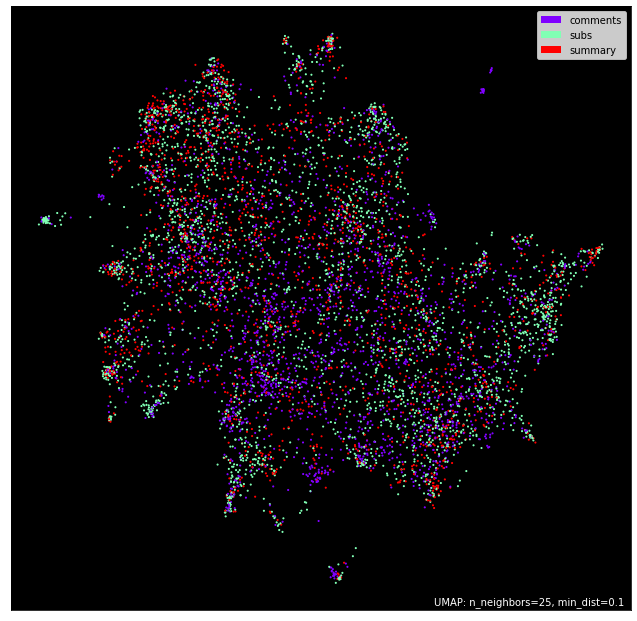

In [22]:
umap.plot.points(g3._umap, labels=ndf['type'], theme='fire')

In [23]:
g3.plot()  # keeps the UMAP positions, unless you press play

<AxesSubplot:>

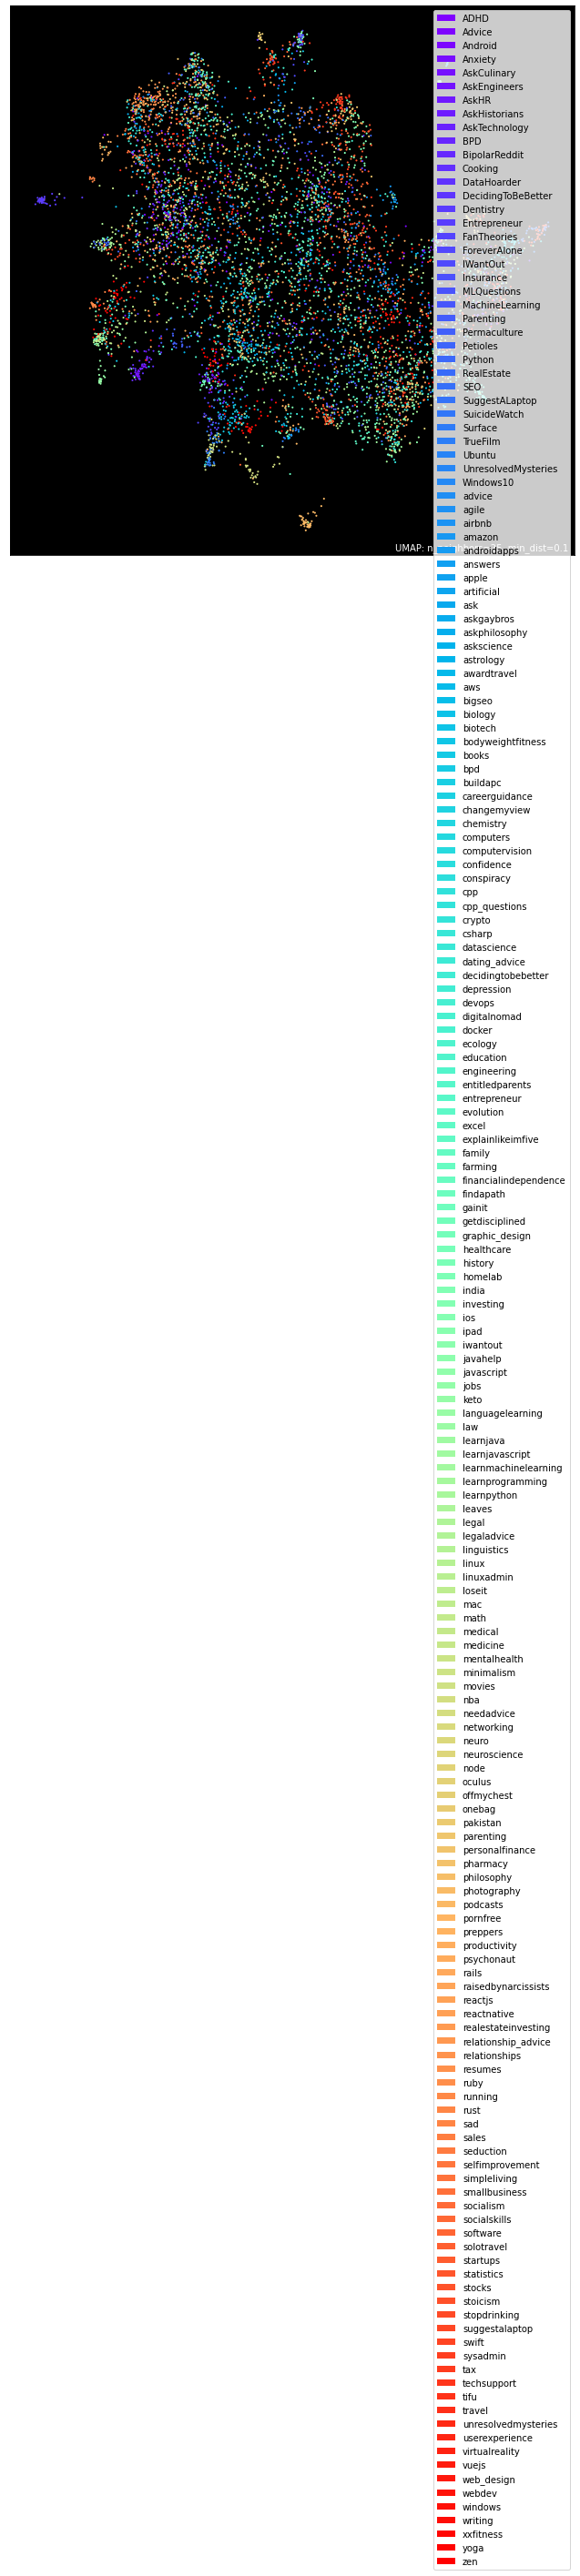

In [24]:
umap.plot.points(g3._umap, labels=ndf['label'], theme='fire')

In [ ]:
#umap.plot.output_notebook()

In [26]:
g3._nodes # notice that there are new columns x, y, weight, that we get from umap-ing. 

,index,title,document,user,type,label,_n,x,y
0,2139309,NEW METAPHOR: Automatic car vs Manual car. My ...,"My brain is a vehicle, getting me places. Peop...",None,subs,ADHD,0,12.078732,20.151554
1,9119685,Anyone know what's up with my neighbor?,TL;DR - neighbor is acting very strangely and ...,/u/Recent_Tadpole_706,summary,advice,1,14.146038,30.828630
2,4309559,I(23F) brought up to my bf(28M) that I'm unhap...,"Sorry, this turned out very long. I just wante...",None,subs,relationships,2,6.881570,30.117348
3,1222530,What cooking pots and pans do you use most?,Inspired by that recent thread about the diffe...,None,subs,Cooking,3,3.904000,12.069092
4,3545420,on Will i ever be normal?,"I am at 142 days and yeah, the brain fog stuck...",None,comments,leaves,4,11.260667,21.990137
...,...,...,...,...,...,...,...,...,...
7056,1938160,on Thinking about majoring in Biotechnology. C...,I do research in experimental therapeutics and...,None,comments,biotech,7056,20.539692,19.420511
7057,3586344,Update: I [F21] am supposed to be having thank...,"Hi, my original post got attention from a few ...",None,subs,relationship_advice,7057,7.789950,30.807995
7058,2139348,I feel like I can only enjoy myself on the day...,Yesterday I had a 3 hour shift from 4pm to 7pm...,None,subs,Anxiety,7058,5.833622,20.827188
7059,7932244,What can I do to get her out?,EDIT: Me - 26. Her - 23(?). I already know the...,/u/randsom1,summary,dating_advice,7059,5.239139,31.885710


In [27]:
g3._edges # new edges when there was no edges before! The magic of featurization and UMAP!

,_src_implicit,_dst_implicit,_weight
5,0,428,1.000000
32,0,2856,1.000000
73,0,6620,0.986908
75,0,6708,1.000000
84,1,2704,1.000000
...,...,...,...
294654,7057,5798,1.000000
294715,7058,112,1.000000
294733,7058,2364,1.000000
294794,7059,6452,1.000000


In [28]:
g3.node_embedding # the UMAP coordinates, directly

array([[12.0787325, 20.151554 ],
       [14.146038 , 30.82863  ],
       [ 6.88157  , 30.117348 ],
       ...,
       [ 5.833622 , 20.827188 ],
       [ 5.2391386, 31.88571  ],
       [ 7.0091496, 31.67507  ]], dtype=float32)

# Let's use the weighted edges calculated implicitly during UMAP-ing the features to produce a bonefide graph

In [29]:
wdf = g3.weighted_edges_df_from_nodes  # this is set when calling .umap()

In [30]:
coldict = dict(zip(range(len(g3._nodes)), g3._nodes['label'].values))  # get the label dict per node

In [31]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13140 entries, 5 to 294796
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   _src_implicit  13140 non-null  int64  
 1   _dst_implicit  13140 non-null  int64  
 2   _weight        13140 non-null  float32
dtypes: float32(1), int64(2)
memory usage: 875.3 KB


In [32]:
wdf['src_label'] = wdf[config.SRC].apply(lambda x: coldict[x]) # map label for the given node as a sanity check
wdf['dst_label'] = wdf[config.DST].apply(lambda x: coldict[x])

# So we see that the weighted edge dataframe gotten from UMAP does a good job at clustering data together that is topically similar. 

In [33]:
wdf

,_src_implicit,_dst_implicit,_weight,src_label,dst_label
5,0,428,1.000000,ADHD,confidence
32,0,2856,1.000000,ADHD,BPD
73,0,6620,0.986908,ADHD,oculus
75,0,6708,1.000000,ADHD,askscience
84,1,2704,1.000000,advice,RealEstate
...,...,...,...,...,...
294654,7057,5798,1.000000,relationship_advice,relationship_advice
294715,7058,112,1.000000,Anxiety,Petioles
294733,7058,2364,1.000000,Anxiety,mentalhealth
294794,7059,6452,1.000000,dating_advice,relationship_advice


# We can plot the edges using the label field (rather than the entity/node_id) to see subreddit similarity

In [34]:
g4 = graphistry.edges(wdf, 'src_label', 'dst_label')
g4.plot()

In [35]:
# Let's see the spread of association
for a, b in wdf.groupby(['src_label', 'dst_label']).groups:
    print(f'{a} <-> {b}')

ADHD <-> ADHD
ADHD <-> Advice
ADHD <-> BPD
ADHD <-> BipolarReddit
ADHD <-> DecidingToBeBetter
ADHD <-> Dentistry
ADHD <-> SuicideWatch
ADHD <-> askphilosophy
ADHD <-> askscience
ADHD <-> books
ADHD <-> bpd
ADHD <-> careerguidance
ADHD <-> confidence
ADHD <-> decidingtobebetter
ADHD <-> entitledparents
ADHD <-> findapath
ADHD <-> getdisciplined
ADHD <-> healthcare
ADHD <-> history
ADHD <-> leaves
ADHD <-> legaladvice
ADHD <-> loseit
ADHD <-> medicine
ADHD <-> mentalhealth
ADHD <-> needadvice
ADHD <-> neuro
ADHD <-> oculus
ADHD <-> raisedbynarcissists
ADHD <-> tifu
ADHD <-> travel
Advice <-> ADHD
Advice <-> Anxiety
Advice <-> BPD
Advice <-> ForeverAlone
Advice <-> advice
Advice <-> agile
Advice <-> artificial
Advice <-> ask
Advice <-> books
Advice <-> buildapc
Advice <-> changemyview
Advice <-> confidence
Advice <-> decidingtobebetter
Advice <-> depression
Advice <-> digitalnomad
Advice <-> entitledparents
Advice <-> explainlikeimfive
Advice <-> findapath
Advice <-> learnmachinelearning


biology <-> Anxiety
biology <-> MachineLearning
biology <-> advice
biology <-> amazon
biology <-> artificial
biology <-> askgaybros
biology <-> askphilosophy
biology <-> askscience
biology <-> biology
biology <-> biotech
biology <-> careerguidance
biology <-> digitalnomad
biology <-> ecology
biology <-> education
biology <-> engineering
biology <-> evolution
biology <-> explainlikeimfive
biology <-> healthcare
biology <-> learnmachinelearning
biology <-> math
biology <-> medical
biology <-> neuro
biology <-> neuroscience
biology <-> productivity
biology <-> statistics
biology <-> stopdrinking
biology <-> unresolvedmysteries
biotech <-> AskEngineers
biotech <-> Entrepreneur
biotech <-> Python
biotech <-> artificial
biotech <-> askscience
biotech <-> biology
biotech <-> biotech
biotech <-> bodyweightfitness
biotech <-> buildapc
biotech <-> careerguidance
biotech <-> chemistry
biotech <-> datascience
biotech <-> findapath
biotech <-> healthcare
biotech <-> learnprogramming
biotech <-> leg

farming <-> medical
farming <-> needadvice
farming <-> podcasts
farming <-> relationships
farming <-> tax
farming <-> tifu
financialindependence <-> Anxiety
financialindependence <-> BPD
financialindependence <-> BipolarReddit
financialindependence <-> IWantOut
financialindependence <-> Permaculture
financialindependence <-> RealEstate
financialindependence <-> careerguidance
financialindependence <-> conspiracy
financialindependence <-> dating_advice
financialindependence <-> entrepreneur
financialindependence <-> financialindependence
financialindependence <-> findapath
financialindependence <-> getdisciplined
financialindependence <-> investing
financialindependence <-> jobs
financialindependence <-> personalfinance
financialindependence <-> preppers
financialindependence <-> realestateinvesting
financialindependence <-> sales
financialindependence <-> simpleliving
financialindependence <-> startups
financialindependence <-> stopdrinking
financialindependence <-> tax
financialindepe

productivity <-> windows
productivity <-> xxfitness
psychonaut <-> Advice
psychonaut <-> BPD
psychonaut <-> ForeverAlone
psychonaut <-> Parenting
psychonaut <-> askphilosophy
psychonaut <-> depression
psychonaut <-> family
psychonaut <-> leaves
psychonaut <-> mentalhealth
psychonaut <-> offmychest
psychonaut <-> philosophy
psychonaut <-> pornfree
psychonaut <-> productivity
psychonaut <-> psychonaut
psychonaut <-> raisedbynarcissists
psychonaut <-> stoicism
psychonaut <-> stopdrinking
psychonaut <-> zen
rails <-> Python
rails <-> agile
rails <-> aws
rails <-> cpp
rails <-> crypto
rails <-> csharp
rails <-> entrepreneur
rails <-> javahelp
rails <-> javascript
rails <-> learnmachinelearning
rails <-> learnprogramming
rails <-> learnpython
rails <-> linuxadmin
rails <-> networking
rails <-> node
rails <-> oculus
rails <-> personalfinance
rails <-> rails
rails <-> reactjs
rails <-> ruby
rails <-> socialskills
rails <-> startups
rails <-> stoicism
rails <-> vuejs
rails <-> web_design
rails 

In [36]:
wdf.groupby(['src_label', 'dst_label'])[config.WEIGHT].agg('mean')

src_label  dst_label         
ADHD       ADHD                  1.0
           Advice                1.0
           BPD                   1.0
           BipolarReddit         1.0
           DecidingToBeBetter    1.0
                                ... 
zen        philosophy            1.0
           psychonaut            1.0
           socialism             1.0
           yoga                  1.0
           zen                   1.0
Name: _weight, Length: 4931, dtype: float32

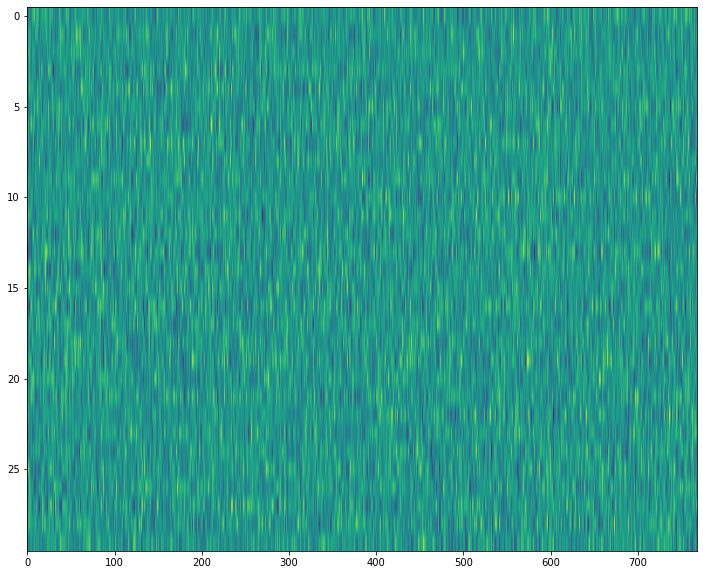

In [37]:
# lets see the node features 
plt.figure(figsize=(12,10)); plt.imshow(g3.node_features[:30], aspect='auto')

In [38]:
g6 = g3.umap(scale=0.1, n_neighbors=40, min_dist=0.1, local_connectivity=30)

[feature_utils.py:1240 -                 umap() ]
   Relabeling nodes

[feature_utils.py:1069 - _featurize_or_get_nodes_dataframe_if_X_is_None() ]
   Found Node features in `res`

[feature_utils.py:1092 - _featurize_or_get_nodes_dataframe_if_X_is_None() ]
   Fetching `node_target` in `res`. Target is type <class 'pandas.core.frame.DataFrame'>

[umap_utils.py:84 - _check_target_is_one_dimensional() ]
   * Ignoring target column of shape (7061, 187) as it is not one dimensional

[umap_utils.py:92 -                  fit() ]
   Starting UMAP-ing data of shape (7061, 768)

[umap_utils.py:105 -      _edge_influence() ]
   Calculating weighted adjacency (edge) DataFrame

[umap_utils.py:96 -                  fit() ]
   -UMAP-ing took 1.57 minutes total

[umap_utils.py:97 -                  fit() ]
    - or 4488.85 rows per minute

[feature_utils.py:829 - prune_weighted_edges_df_and_relabel_nodes() ]
   edge weights: mean(0.79), std(0.39), max(1.0), min(0.00), thresh(0.96)

[feature_utils.py:83

<AxesSubplot:>

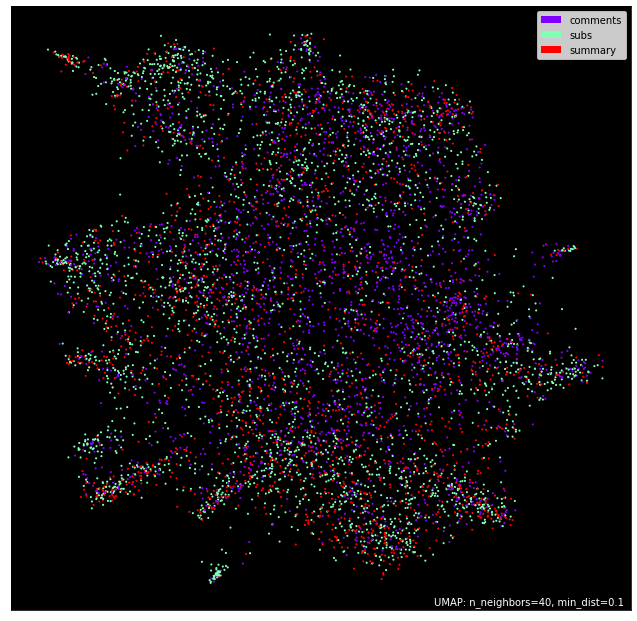

In [39]:
umap.plot.points(g6._umap, labels=ndf['type'], theme='fire')

In [40]:
g6.plot() 

# Let's test how well featurization predicts category

In [41]:
from sklearn.preprocessing import LabelBinarizer, label_binarize
lbin = LabelBinarizer()

In [42]:
T = lbin.fit_transform(single_target)

In [43]:
T.shape

(7061, 187)

In [44]:
X = g3.node_features
X.shape

(7061, 768)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

clf = RandomForestClassifier()

# a, b, c, d = train_test_split(X, T, train_size=0.8)

# # this takes so long and scores bad -- which makes sense as RF doesn't do well on embedding vectors
# clf.fit(a, c)
# clf.score(b, d) 
# preds = clf.predict(b)
# print(classification_report(d, preds))
# ConfusionMatrixDisplay.from_predictions(d.argmax(1), preds.argmax(1))

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
tvect = TfidfVectorizer(min_df=3, max_df=0.3, ngram_range=(1, 3))
M = tvect.fit_transform(ndf.document)

In [48]:
M.shape, T.shape

((7061, 142978), (7061, 187))

In [49]:
a, b, c, d = train_test_split(M, T, train_size=0.8)

clf.fit(a, c)
clf.score(b, d) 

0.04670912951167728

In [50]:
preds = clf.predict(b)
print(classification_report(d, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        11
           7       1.00      0.12      0.22         8
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00        12
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         9
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       1.00      0.41      0.58        17
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         9
          17       0.00    

# Compare this to using the graph structure

In [78]:
from graphistry.feature_utils import process_textual_or_other_dataframes

In [70]:
from graphistry.networks import SAGE

In [79]:
use_one_hot= True

if use_one_hot:
    # pass in a df of targets, recall one has to set index
    y_node = pd.DataFrame({col:val for col, val in enumerate(T.T)}, index=ndf.index)
    g5 = g3.build_dgl_graph( 
                    y_nodes=y_node,
                    )
    names = lbin.classes_
else:
    # this model does about the same as the one-hot-encoded 
    # can make new effective target without having to run the whole thing
    y_node, _, _, _ = process_textual_or_other_dataframes(df=double_target, y=None, cardinality_threshold=preds.shape[1]//3)
    # g3 has the node embeddings
    names = y_node.columns
    g5 = g3.build_dgl_graph(
                    y_nodes=y_node,
                    )


[dgl_utils.py:119 - _convert_edgeDF_to_DGL() ]
   converting edge DataFrame to DGL graph

[dgl_utils.py:80 - _remove_edges_not_in_nodes() ]
   Length of edge DataFrame 13140

[dgl_utils.py:86 - _remove_edges_not_in_nodes() ]
   Length of edge DataFrame 13140 after pruning

[dgl_utils.py:34 -  pandas_to_dgl_graph() ]
   Graph Type: <class 'dgl.heterograph.DGLHeteroGraph'>

[dgl_utils.py:97 - _check_nodes_lineup_with_edges() ]
   7061 entities from column _n
 with 7061 unique entities

[dgl_utils.py:147 - _featurize_nodes_to_dgl() ]
   Running Node Featurization for DGL Graph

[feature_utils.py:1069 - _featurize_or_get_nodes_dataframe_if_X_is_None() ]
   Found Node features in `res`

[dgl_utils.py:168 - _featurize_edges_to_dgl() ]
   Running Edge Featurization for DGL Graph

[feature_utils.py:1126 - _featurize_or_get_edges_dataframe_if_X_is_None() ]
   Calling `featurize` to create data matrix `X` over edges DataFrame

[feature_utils.py:738 - process_edge_dataframes() ]
   Encoding Edges

In [80]:
G = g5.DGL_graph
G

Graph(num_nodes=7061, num_edges=13140,
      ndata_schemes={'feature': Scheme(shape=(768,), dtype=torch.float64), 'target': Scheme(shape=(187,), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'feature': Scheme(shape=(7062,), dtype=torch.float64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)})

In [81]:
node_labels = G.ndata['target'].float()
labels = node_labels.argmax(1)
node_features = G.ndata['feature'].float()
n_features = node_features.shape[1]

latent_dim = 42
n_labels = node_labels.shape[1]

train_mask = G.ndata['train_mask']
test_mask = G.ndata['test_mask']

In [99]:
model = SAGE(in_feats=n_features, hid_feats=latent_dim, out_feats=n_labels)

pred = model(G, node_features) # untrained logits
pred.shape

torch.Size([7061, 187])

In [100]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels.argmax(1))
        return correct.item() * 1.0 / len(labels)

In [101]:
opt = torch.optim.Adam(model.parameters())

if use_one_hot:
    n_epochs = 401
else:
    n_epochs = 2001
for epoch in range(n_epochs):
    model.train()
    # forward propagation by using all nodes
    logits = model(G, node_features)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    # compute validation accuracy
    acc = evaluate(model, G, node_features, node_labels, test_mask)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch %200==0:
        print(f'epoch: {epoch} -------\nloss: {loss.item():.4f}')
        print(f'\tAcc: {acc:.4f}')


epoch: 0 -------
loss: 6.4389
	Acc: 0.0055
epoch: 200 -------
loss: 0.1499
	Acc: 0.1860
epoch: 400 -------
loss: 0.0229
	Acc: 0.1936
epoch: 600 -------
loss: 0.0096
	Acc: 0.1909


In [94]:
logits = model(G, node_features)
preds = label_binarize(logits.argmax(1), classes=range(n_labels))

preds_true = node_labels.detach().numpy()

# how well does it perform on hold out set? 
aa, bb = preds_true[test_mask], preds[test_mask]
print(classification_report(aa.argmax(1), bb.argmax(1), target_names=names))

                       precision    recall  f1-score   support

                 ADHD       0.00      0.00      0.00         9
               Advice       0.00      0.00      0.00         8
              Android       0.00      0.00      0.00         2
              Anxiety       0.00      0.00      0.00         3
          AskCulinary       0.50      0.33      0.40         6
         AskEngineers       0.00      0.00      0.00         8
                AskHR       0.50      0.12      0.20         8
        AskHistorians       0.19      0.23      0.21        13
        AskTechnology       0.00      0.00      0.00         9
                  BPD       0.07      0.09      0.08        11
        BipolarReddit       0.00      0.00      0.00         5
              Cooking       0.60      0.38      0.46         8
          DataHoarder       0.40      0.29      0.33         7
   DecidingToBeBetter       0.00      0.00      0.00         4
            Dentistry       0.54      0.88      0.67  

In [95]:
print(classification_report(preds_true.argmax(1), preds.argmax(1), target_names=names))

                       precision    recall  f1-score   support

                 ADHD       0.72      0.74      0.73        35
               Advice       0.76      0.70      0.73        27
              Android       0.92      0.92      0.92        24
              Anxiety       0.85      0.91      0.88        32
          AskCulinary       0.94      0.88      0.91        34
         AskEngineers       0.76      0.62      0.68        21
                AskHR       0.96      0.77      0.86        31
        AskHistorians       0.78      0.82      0.80        56
        AskTechnology       0.84      0.70      0.76        30
                  BPD       0.77      0.82      0.79        56
        BipolarReddit       0.81      0.77      0.79        22
              Cooking       0.93      0.84      0.88        31
          DataHoarder       0.90      0.84      0.87        31
   DecidingToBeBetter       0.79      0.85      0.81        26
            Dentistry       0.89      0.98      0.94  